<h1 align="center">世界幸福指数的构成结构与时间趋势分析</h1>
<h2 align="center">——以 2024 年排名前后十国为例</h2>




**摘要：**  
世界幸福指数（World Happiness Index）通过经济产出、社会支持、健康预期寿命、人生选择自由、慷慨程度与廉洁感知等多维指标综合刻画居民的主观幸福水平。本文基于《World Happiness Report 2025》中 Figure 2.1 的数据，选取 2024 年幸福指数排名前 10 与后 10 的国家，通过叠加条形图分解各构成因素对幸福指数的贡献，比较不同国家的幸福结构差异。同时，本文进一步利用时间序列数据分析 Top10 国家近十年幸福指数的变化趋势。结果表明：经济与健康是高幸福国家的基础性支撑，社会支持与制度信任是区分高幸福与低幸福国家的关键变量，而低幸福国家普遍存在“可解释因素不足、Dystopia + residual 占比过高”的结构性短板。时间趋势分析显示，高幸福国家具有更强的幸福稳定性与制度韧性。本文展示了利用 Python 与 plotnine 实现主题图表构建、时间趋势分析与美化的完整流程，可为多指标指数类数据的可视化研究提供参考。



## 1. 引言（Introduction）

随着经济与社会的发展，“幸福感”逐渐成为衡量国家发展质量的重要维度。
世界幸福指数（World Happiness Index）由联合国可持续发展解决方案网络
（Sustainable Development Solutions Network）每年发布，基于大规模问卷调查，
综合考虑生活满意度评估（life evaluation）、人均 GDP、社会支持、健康预期寿命、
人生选择自由、慷慨程度以及廉洁感知等因素，对各国居民的主观生活质量进行量化。

相比于单一的经济指标，世界幸福指数更强调“多维度福祉”的观念。
然而，在实际阅读报告时，读者往往只能看到各国幸福指数的最终得分，
难以直观理解“每一分幸福”具体由哪些因素构成：

- 高幸福国家是否主要依赖经济和健康优势？  
- 社会支持与自由在不同国家之间扮演怎样的角色？  
- 低幸福国家是否存在某些明显的结构性短板？

为回答上述问题，本文基于《World Happiness Report 2025》中 Figure 2.1 所使用的
数据表 `WHR25_Data_Figure_2.1v3.xlsx`，选取 2024 年幸福指数排名前 10 与后 10 的国家，
通过 Python 与 plotnine 绘制叠加条形图，将总幸福指数拆解为各构成因素的叠加，
并在此基础上进行对比分析。希望通过图表，使读者能够更直观地观察到
“幸福结构”的差异，而不仅仅停留在总分高低的比较上。


## 2. 数据来源与预处理（Data Source and Preprocessing）

### 2.1 环境初始化与字体设置

本节首先导入分析和可视化所需的 Python 库，并在 Windows 环境下优先使用合适的
中文字体（如宋体、黑体或微软雅黑），同时将该字体传递给 plotnine 的全局主题配置，
以保证图例、坐标轴标签及标题的中文能够正常显示。


In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import font_manager
import warnings
from plotnine import *
from IPython.display import display

# 自动寻找中文字体
system_fonts = set(f.name for f in font_manager.fontManager.ttflist)
if "SimSun" in system_fonts:
    CHINESE_FONT = "SimSun"
elif "SimHei" in system_fonts:
    CHINESE_FONT = "SimHei"
elif "Microsoft YaHei" in system_fonts:
    CHINESE_FONT = "Microsoft YaHei"
else:
    CHINESE_FONT = "sans-serif"  # 没找到就用默认

print(f"已选择字体: {CHINESE_FONT}")

# 设置 matplotlib 基础配置，避免负号显示问题
matplotlib.rcParams['font.family'] = CHINESE_FONT
matplotlib.rcParams['axes.unicode_minus'] = False

# 设置 plotnine 全局主题
theme_set(
    theme_bw() +
    theme(
        text=element_text(family=CHINESE_FONT),
        legend_position="bottom",
        legend_direction="horizontal",
        legend_title=element_blank(),
        axis_text_x=element_text(rotation=35, ha="right"),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        axis_line=element_line(size=1.0, color="black")
    )
)

# 忽略不重要的告警
warnings.filterwarnings("ignore")


已选择字体: SimSun


### 2.2 数据读取与字段概览

本文使用的数据来自《World Happiness Report 2025》随附的 Excel 文件  
**`WHR25_Data_Figure_2.1v3.xlsx`**。该文件包含多个年份、多个国家的幸福指数及其分解项。
在原始数据中，每一行代表某一国家在某一年的观测值，主要包括以下几类字段：

- 年份与排名：`Year`、`Rank`  
- 国家信息：`Country name`  
- 总体幸福评估：`Life evaluation (3-year average)`  
- 置信区间：`Lower whisker`、`Upper whisker`  
- 各构成因素的解释量（Explained by ...）：人均 GDP（对数）、社会支持、健康预期寿命、
  人生选择自由、慷慨程度、廉洁感知等  
- `Dystopia + residual`：对无法由上述因素解释部分的基准与残差项。


In [2]:
# 假定 Excel 数据文件与本 Notebook 位于同一目录
excel_path = "WHR25_Data_Figure_2.1v3.xlsx"

whr = pd.read_excel(excel_path)
print("原始数据规模：", whr.shape)
display(whr.head())
print("\n列名：")
print(list(whr.columns))


原始数据规模： (1969, 13)


,Year,Rank,Country name,Life evaluation (3-year average),Lower whisker,Upper whisker,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,2024,147,Afghanistan,1.364,1.301,1.427,0.649,0.0,0.155,0.0,0.075,0.135,0.348
1,2023,143,Afghanistan,1.721,1.667,1.775,0.628,0.0,0.242,0.0,0.091,0.088,0.672
2,2022,137,Afghanistan,1.859,1.795,1.923,0.645,0.0,0.087,0.0,0.093,0.059,0.976
3,2021,146,Afghanistan,2.404,2.339,2.469,0.758,0.0,0.289,0.0,0.089,0.005,1.263
4,2020,150,Afghanistan,2.523,2.449,2.596,0.370,0.0,0.126,0.0,0.122,0.010,1.895



列名：
['Year', 'Rank', 'Country name', 'Life evaluation (3-year average)', 'Lower whisker', 'Upper whisker', 'Explained by: Log GDP per capita', 'Explained by: Social support', 'Explained by: Healthy life expectancy', 'Explained by: Freedom to make life choices', 'Explained by: Generosity', 'Explained by: Perceptions of corruption', 'Dystopia + residual']


### 2.3 样本筛选：2024 年 Top10 与 Bottom10

由于原始数据覆盖多个年份，若全部纳入分析，图表会变得过于复杂。
本文聚焦于最新一年的状况，因此只保留 `Year = 2024` 的观测值。在此基础上，
根据 `Rank` 变量进行排序：

- 选取排名 **前 10 名** 的国家作为 **Top10 样本**；  
- 选取排名 **后 10 名** 的国家作为 **Bottom10 样本**。

这样的样本设计一方面保证图表规模适中，便于阅读和比较；另一方面，Top10 与 Bottom10
之间形成鲜明对照，有利于观察幸福结构的差异。


In [3]:
# 只保留 2024 年
whr_2024 = whr[whr["Year"] == 2024].copy()
print("2024 年数据条数：", len(whr_2024))

# 按 Rank 排序
whr_2024 = whr_2024.sort_values("Rank")

# 选取前 10 与后 10
top10 = whr_2024.nsmallest(10, "Rank").copy()
bottom10 = whr_2024.nlargest(10, "Rank").copy()

print("Top10 Countries (Rank, Country, LifeEval):")
display(top10[["Rank", "Country name", "Life evaluation (3-year average)"]])

print("\nBottom10 Countries (Rank, Country, LifeEval):")
display(bottom10[["Rank", "Country name", "Life evaluation (3-year average)"]])


2024 年数据条数： 147
Top10 Countries (Rank, Country, LifeEval):


,Rank,Country name,Life evaluation (3-year average)
563,1,Finland,7.736
455,2,Denmark,7.521
735,3,Iceland,7.515
1671,4,Sweden,7.345
1235,5,Netherlands,7.306
390,6,Costa Rica,7.274
1322,7,Norway,7.262
813,8,Israel,7.234
1028,9,Luxembourg,7.122
1134,10,Mexico,6.979



Bottom10 Countries (Rank, Country, LifeEval):


,Rank,Country name,Life evaluation (3-year average)
0,147,Afghanistan,1.364
1539,146,Sierra Leone,2.998
967,145,Lebanon,3.188
1054,144,Malawi,3.260
1956,143,Zimbabwe,3.396
207,142,Botswana,3.438
484,141,DR Congo,3.469
1931,140,Yemen,3.561
366,139,Comoros,3.754
980,138,Lesotho,3.757


### 2.4 构成因素列的重命名与长表转换

在原始数据中，各构成因素的列名前均带有 `Explained by:` 前缀，例如：
`Explained by: Log GDP per capita`。这一命名虽然严谨，但列名较长，
在代码中频繁引用不够直观。因此，本文首先将相关列重命名为简短的英文变量名，
例如 `Log_GDP_per_capita`、`Social_support` 等。随后，为方便使用叠加条形图，
将“每一行代表一个国家”的宽表（wide format）转换为“每一行代表一个国家 + 一个构成因素”
的长表（long format），并增加中文因素标签 `Factor_zh`，作为后续图例显示使用。


In [4]:
# 关注的构成因素原始列名
factor_cols_original = [
    "Explained by: Log GDP per capita",
    "Explained by: Social support",
    "Explained by: Healthy life expectancy",
    "Explained by: Freedom to make life choices",
    "Explained by: Generosity",
    "Explained by: Perceptions of corruption",
    "Dystopia + residual",
]

# 重命名映射
rename_map = {
    "Explained by: Log GDP per capita": "Log_GDP_per_capita",
    "Explained by: Social support": "Social_support",
    "Explained by: Healthy life expectancy": "Healthy_life_expectancy",
    "Explained by: Freedom to make life choices": "Freedom",
    "Explained by: Generosity": "Generosity",
    "Explained by: Perceptions of corruption": "Perceptions_of_corruption",
    "Dystopia + residual": "Dystopia_residual",
}

# 应用重命名
top10_renamed = top10.rename(columns=rename_map)
bottom10_renamed = bottom10.rename(columns=rename_map)

# 简短英文列名列表
factor_cols = [
    "Log_GDP_per_capita",
    "Social_support",
    "Healthy_life_expectancy",
    "Freedom",
    "Generosity",
    "Perceptions_of_corruption",
    "Dystopia_residual",
]

print("Top10 构成因素列名：")
print([c for c in top10_renamed.columns if c in factor_cols])


Top10 构成因素列名：
['Log_GDP_per_capita', 'Social_support', 'Healthy_life_expectancy', 'Freedom', 'Generosity', 'Perceptions_of_corruption', 'Dystopia_residual']


## 3. 可视化设计与实现（Visualization Method）

### 3.1 图表类型选择：叠加条形图

世界幸福指数本质上是多个构成因素的加总。为了直观展示“一个国家的总分是如何由多种因素叠加而来”，
叠加条形图（stacked bar chart）是一个非常自然的选择：

- 横轴：国家名称；  
- 纵轴：各构成因素贡献值之和（即总幸福指数）；  
- 填充颜色：不同的构成因素（人均 GDP、社会支持等）。  

与普通条形图相比，叠加条形图不仅展示了总量的高低，还揭示了**内部结构的差异**。

### 3.2 审美映射与排序策略

在 plotnine 中，我们将：

- `x` 映射为 `Country name`；  
- `y` 映射为 `Contribution`（各构成因素的解释量）；  
- `fill` 映射为 `Factor_zh`（中文的构成因素名称）。  

为了使图表更符合人类阅读习惯，本项目将国家按照 `Rank` 排序后，显式设置为有序类别型变量，
保证图中国家的顺序与幸福指数排名一致。

### 3.3 渐进式图表构建思路

参考课堂案例与范文风格，本项目采用“从简到繁、逐步美化”的图表构建方式：

1. 基础叠加条形图：只包含基本的 x、y 和 fill 映射，用于检查数据是否正确；  
2. 加入主题与配色：通过 `scale_fill_brewer` 以及 `theme_bw` 等语句，统一配色风格；  
3. 添加数值标签：在柱体内部添加部分贡献值，在柱体顶部添加总幸福指数，提高信息密度；  
4. 调整字体与坐标轴标签：保证中文标题、图例和坐标轴的字号与字体统一，方便论文中引用与排版。


In [5]:
# Top10: 宽表 -> 长表
top10_long = top10_renamed.melt(
    id_vars=["Rank", "Country name", "Life evaluation (3-year average)"],
    value_vars=factor_cols,
    var_name="Factor_en",
    value_name="Contribution",
)

# 中文标签映射
factor_label_map = {
    "Log_GDP_per_capita": "人均 GDP（对数）",
    "Social_support": "社会支持",
    "Healthy_life_expectancy": "健康预期寿命",
    "Freedom": "人生选择自由",
    "Generosity": "慷慨程度",
    "Perceptions_of_corruption": "廉洁感知",
    "Dystopia_residual": "反乌托邦基准 + 残差",
}

top10_long["Factor_zh"] = top10_long["Factor_en"].map(factor_label_map)

# 国家按排名设置为有序类别
ordered_countries_top = top10_renamed.sort_values("Rank")["Country name"].tolist()
top10_long["Country name"] = pd.Categorical(
    top10_long["Country name"],
    categories=ordered_countries_top,
    ordered=True,
)

display(top10_long.head())


,Rank,Country name,Life evaluation (3-year average),Factor_en,Contribution,Factor_zh
0,1,Finland,7.736,Log_GDP_per_capita,1.749,人均 GDP（对数）
1,2,Denmark,7.521,Log_GDP_per_capita,1.825,人均 GDP（对数）
2,3,Iceland,7.515,Log_GDP_per_capita,1.799,人均 GDP（对数）
3,4,Sweden,7.345,Log_GDP_per_capita,1.783,人均 GDP（对数）
4,5,Netherlands,7.306,Log_GDP_per_capita,1.822,人均 GDP（对数）


## 4. 实证结果与分析（Empirical Results）

### 4.1 Top10 国家：基础叠加条形图

首先绘制一个不加任何美化的基础叠加条形图，用于检查数据映射是否正确。


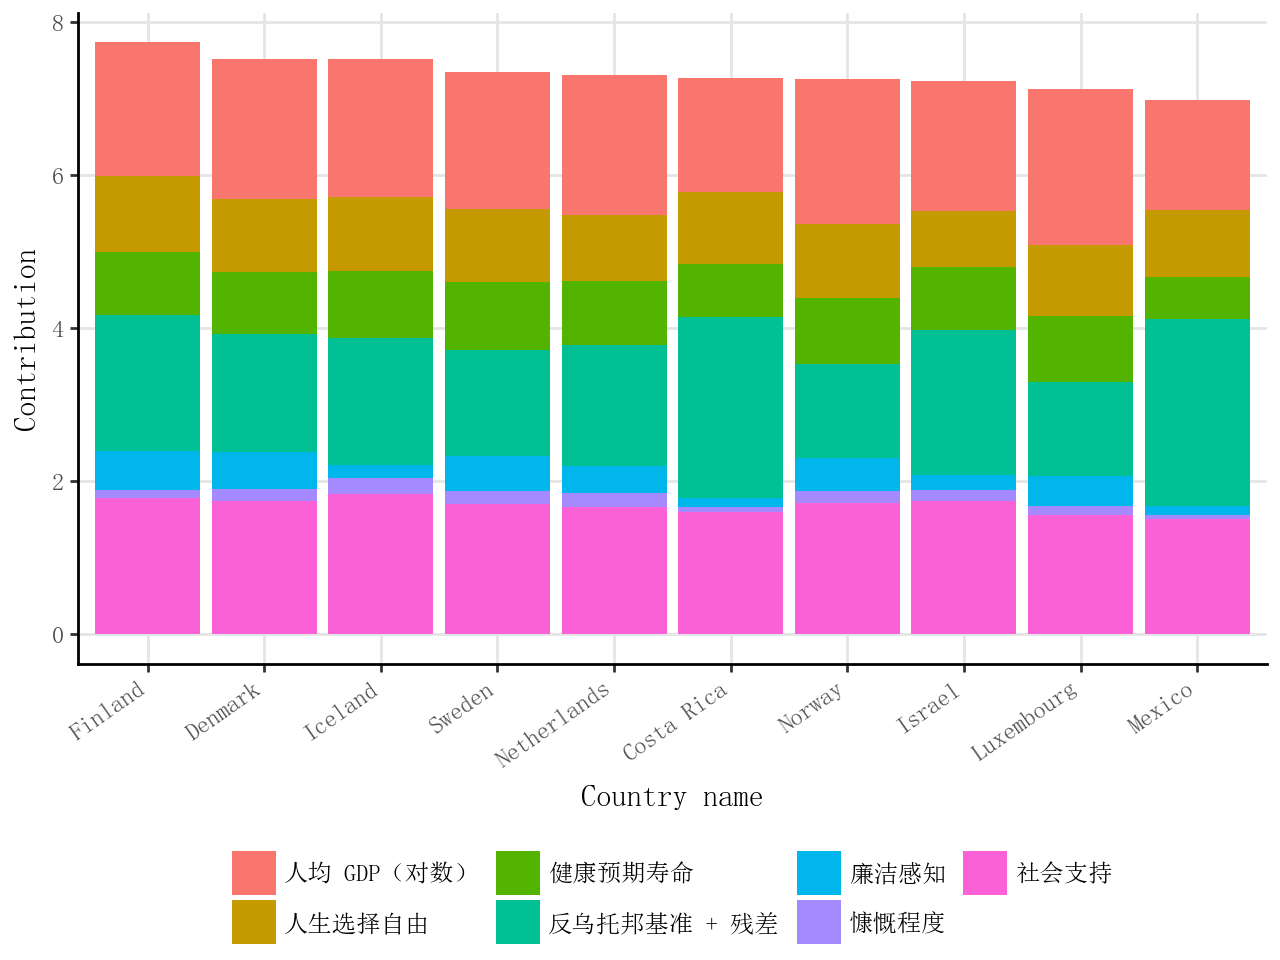

In [6]:
p_top_basic = (
    ggplot(top10_long, aes(x="Country name", y="Contribution", fill="Factor_zh"))
    + geom_col()
)
p_top_basic


### 4.2 Top10 国家：主题美化与轴标签

在基础图的基础上，加入统一的配色方案、标题与坐标轴标签，并适当调整主题，
使图表风格更适合论文排版。


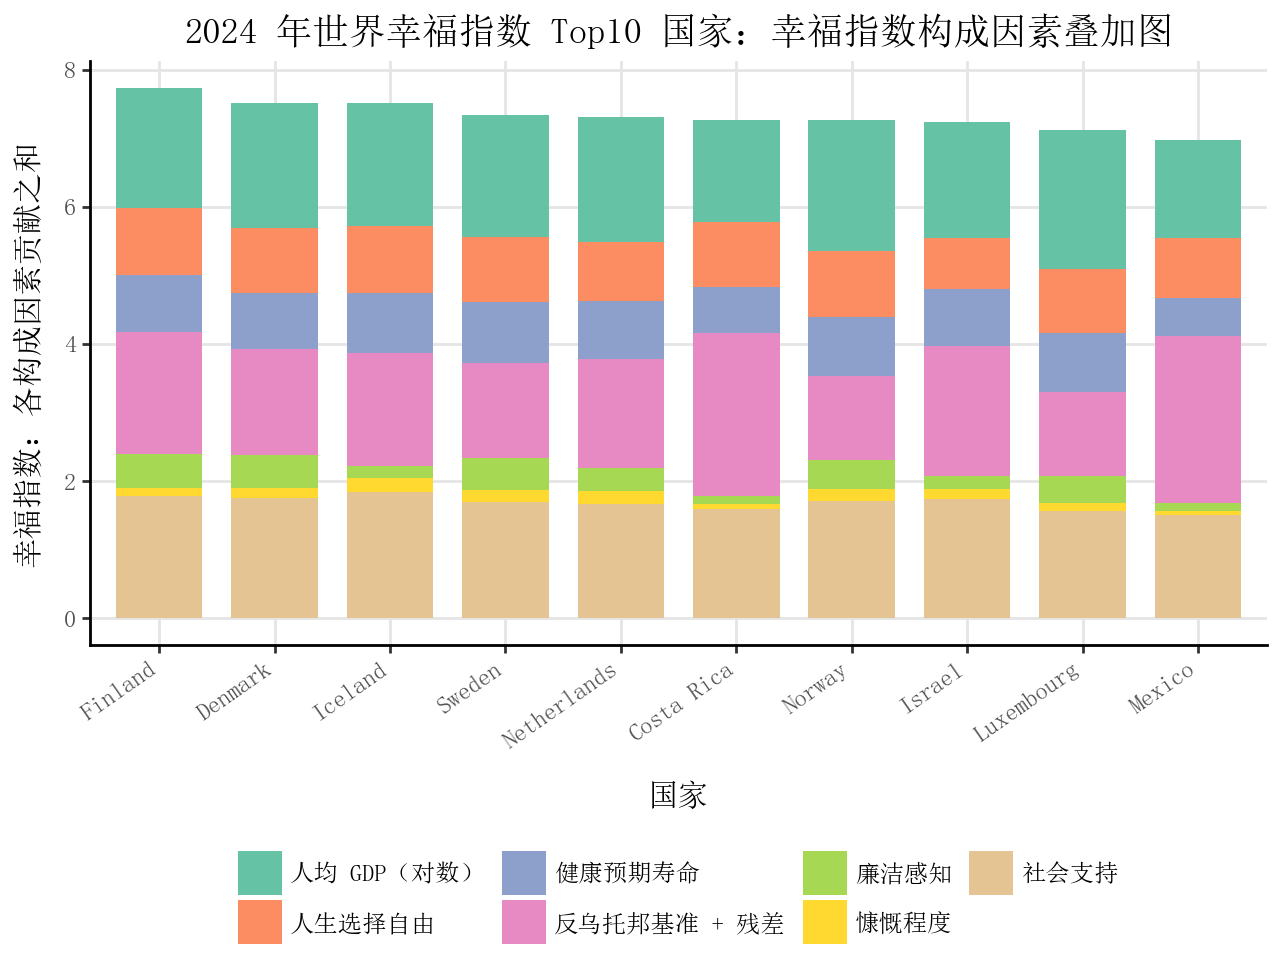

In [7]:
p_top = (
    ggplot(top10_long, aes(x="Country name", y="Contribution", fill="Factor_zh"))
    + geom_col(width=0.75)
    + scale_fill_brewer(type="qual", palette="Set2")
    + ggtitle("2024 年世界幸福指数 Top10 国家：幸福指数构成因素叠加图")
    + xlab("国家")
    + ylab("幸福指数：各构成因素贡献之和")
    + theme_bw()
    + theme(
        text=element_text(family=CHINESE_FONT),
        legend_position="bottom",
        legend_direction="horizontal",
        legend_title=element_blank(),
        axis_text_x=element_text(rotation=35, ha="right"),
        axis_title_x=element_text(margin={"t": 8}),
        axis_title_y=element_text(margin={"r": 8}),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        axis_line=element_line(size=1.0, color="black"),
    )
)
p_top


### 4.3 Top10 国家：添加总分与内部数值标签

为了提高图表的信息密度，在柱体内部添加各构成因素的贡献值标签（对较小的部分不显示，避免重叠），
并在柱体顶部添加每个国家的总体幸福指数，便于精确比较。


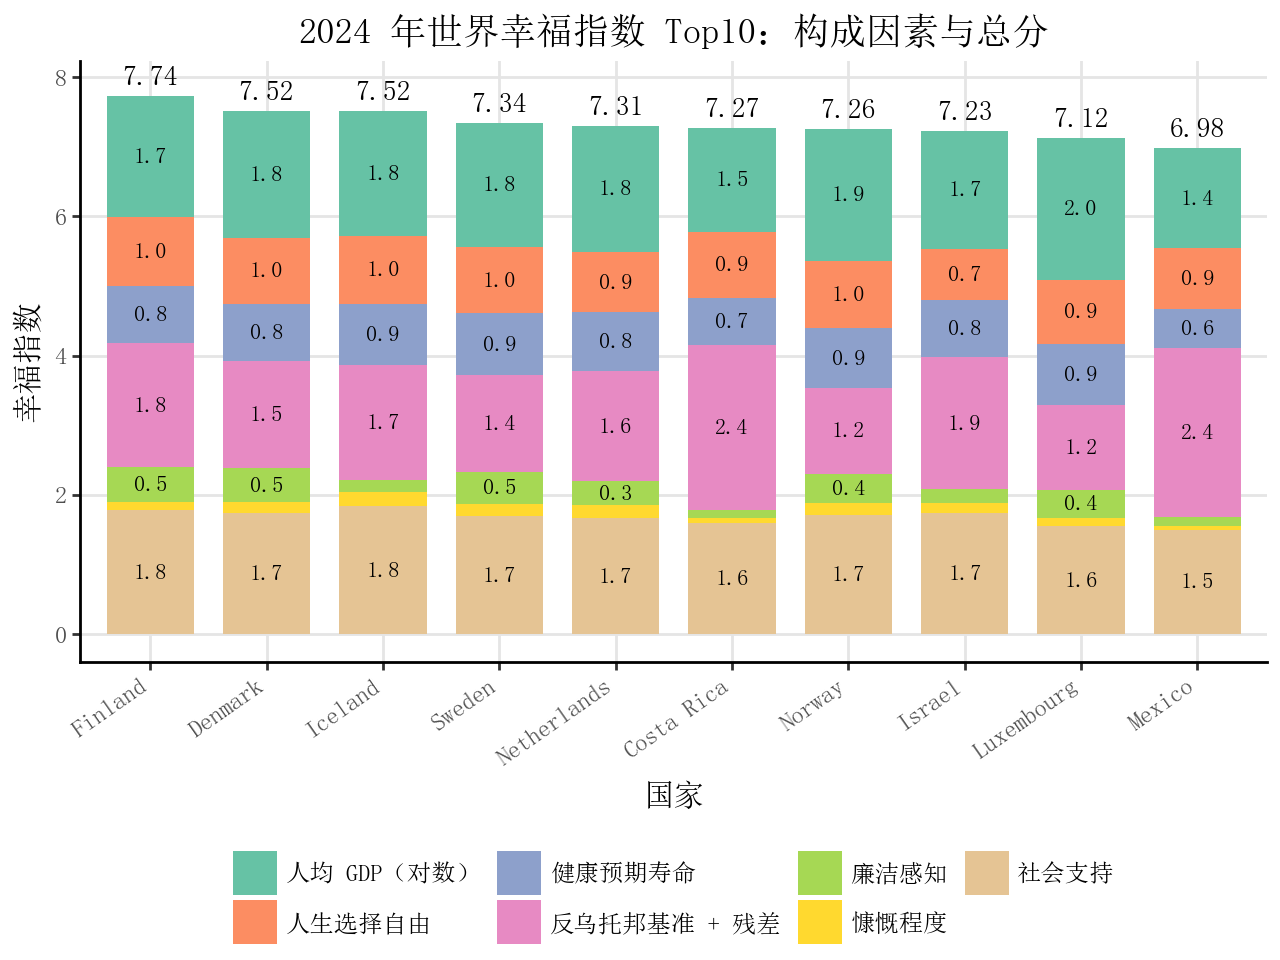

In [8]:
# 顶部总分标签数据
label_top = top10_renamed[["Country name", "Life evaluation (3-year average)"]].copy()
label_top["LifeEval_pos"] = label_top["Life evaluation (3-year average)"] + 0.1
label_top["LifeEval_text"] = label_top["Life evaluation (3-year average)"].round(2).astype(str)
label_top["Country name"] = pd.Categorical(
    label_top["Country name"],
    categories=ordered_countries_top,
    ordered=True,
)

# 内部数值标签：只保留贡献值 > 0.25 的部分
top10_long["Label_Inner"] = top10_long["Contribution"].apply(
    lambda x: f"{x:.1f}" if x > 0.25 else ""
)

p_top_final = (
    ggplot(top10_long, aes(x="Country name", y="Contribution", fill="Factor_zh"))
    + geom_col(width=0.75)
    + geom_text(
        aes(label="Label_Inner"),
        position=position_stack(vjust=0.5),
        size=8,
        color="black",
    )
    + scale_fill_brewer(type="qual", palette="Set2")
    + ggtitle("2024 年世界幸福指数 Top10：构成因素与总分")
    + xlab("国家")
    + ylab("幸福指数")
    + geom_text(
        data=label_top,
        mapping=aes(x="Country name", y="LifeEval_pos", label="LifeEval_text"),
        size=10,
        va="bottom",
        inherit_aes=False,
    )
)
p_top_final


### 4.4 Bottom10 国家：幸福指数构成特征

下面对 2024 年幸福指数排名后 10 的国家绘制叠加条形图，并同样添加数值标签，
用于与 Top10 形成对比。


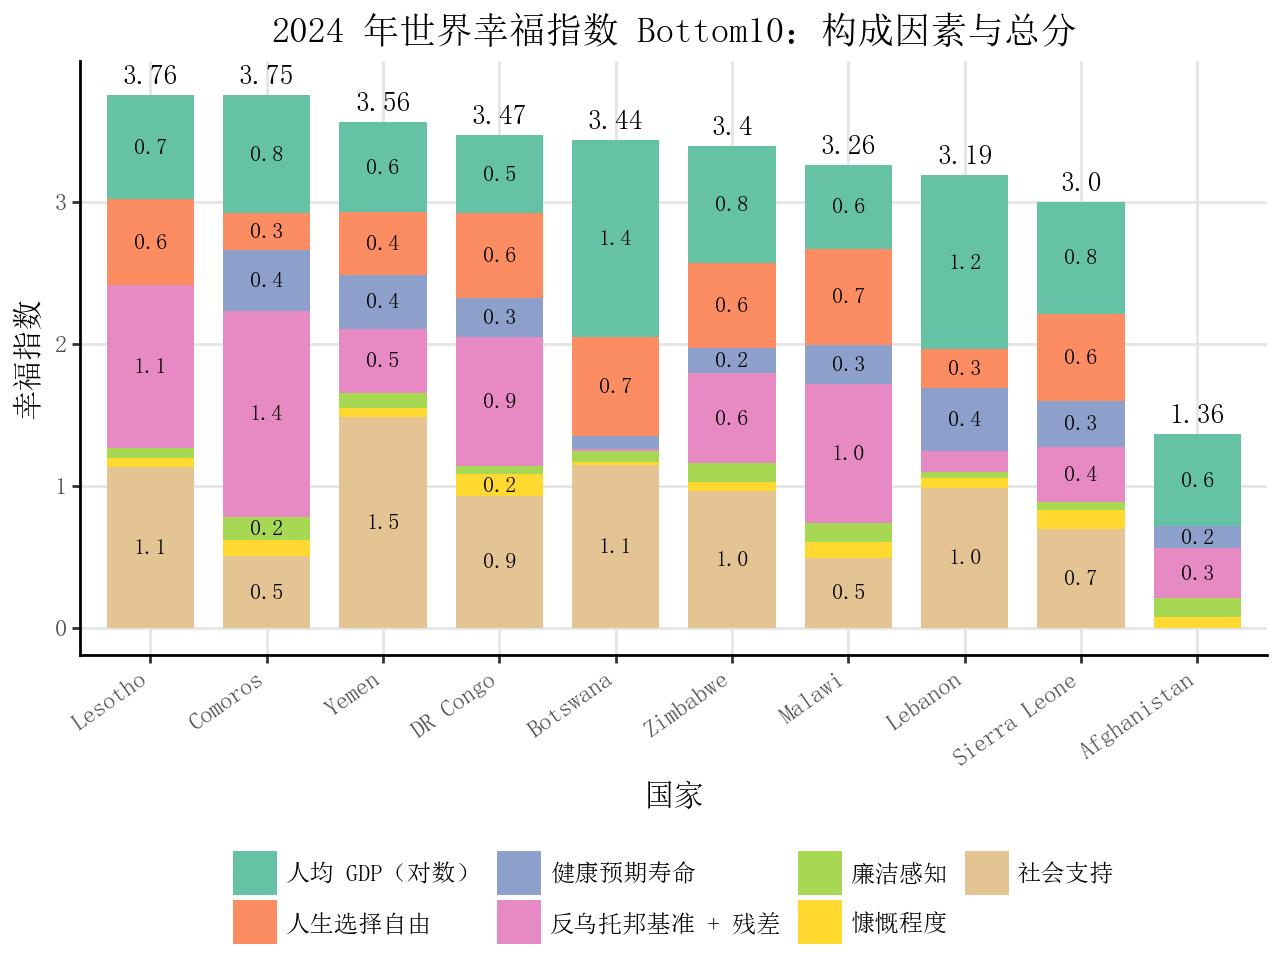

In [9]:
# Bottom10: 宽表 -> 长表
bottom10_long = bottom10_renamed.melt(
    id_vars=["Rank", "Country name", "Life evaluation (3-year average)"],
    value_vars=factor_cols,
    var_name="Factor_en",
    value_name="Contribution",
)
bottom10_long["Factor_zh"] = bottom10_long["Factor_en"].map(factor_label_map)

# Bottom10 国家排序（Rank 从小到大）
ordered_countries_bottom = bottom10_renamed.sort_values("Rank")["Country name"].tolist()
bottom10_long["Country name"] = pd.Categorical(
    bottom10_long["Country name"],
    categories=ordered_countries_bottom,
    ordered=True,
)

# 内部数值标签：阈值略降低，避免过多空白
bottom10_long["Label_Inner"] = bottom10_long["Contribution"].apply(
    lambda x: f"{x:.1f}" if x > 0.15 else ""
)

# 顶部总分标签
label_bottom = bottom10_renamed[["Country name", "Life evaluation (3-year average)"]].copy()
label_bottom["LifeEval_pos"] = label_bottom["Life evaluation (3-year average)"] + 0.05
label_bottom["LifeEval_text"] = label_bottom["Life evaluation (3-year average)"].round(2).astype(str)
label_bottom["Country name"] = pd.Categorical(
    label_bottom["Country name"],
    categories=ordered_countries_bottom,
    ordered=True,
)

p_bottom = (
    ggplot(bottom10_long, aes(x="Country name", y="Contribution", fill="Factor_zh"))
    + geom_col(width=0.75)
    + geom_text(
        aes(label="Label_Inner"),
        position=position_stack(vjust=0.5),
        size=8,
        color="black",
    )
    + scale_fill_brewer(type="qual", palette="Set2")
    + ggtitle("2024 年世界幸福指数 Bottom10：构成因素与总分")
    + xlab("国家")
    + ylab("幸福指数")
    + geom_text(
        data=label_bottom,
        mapping=aes(x="Country name", y="LifeEval_pos", label="LifeEval_text"),
        size=10,
        va="bottom",
        inherit_aes=False,
    )
)
p_bottom


### 4.5 Top10 与 Bottom10 的分面对比图

为了更直观地比较 Top10 与 Bottom10 的差异，本节使用分面（facet）的方式，
将两组国家的构成因素放在同一图中展示。


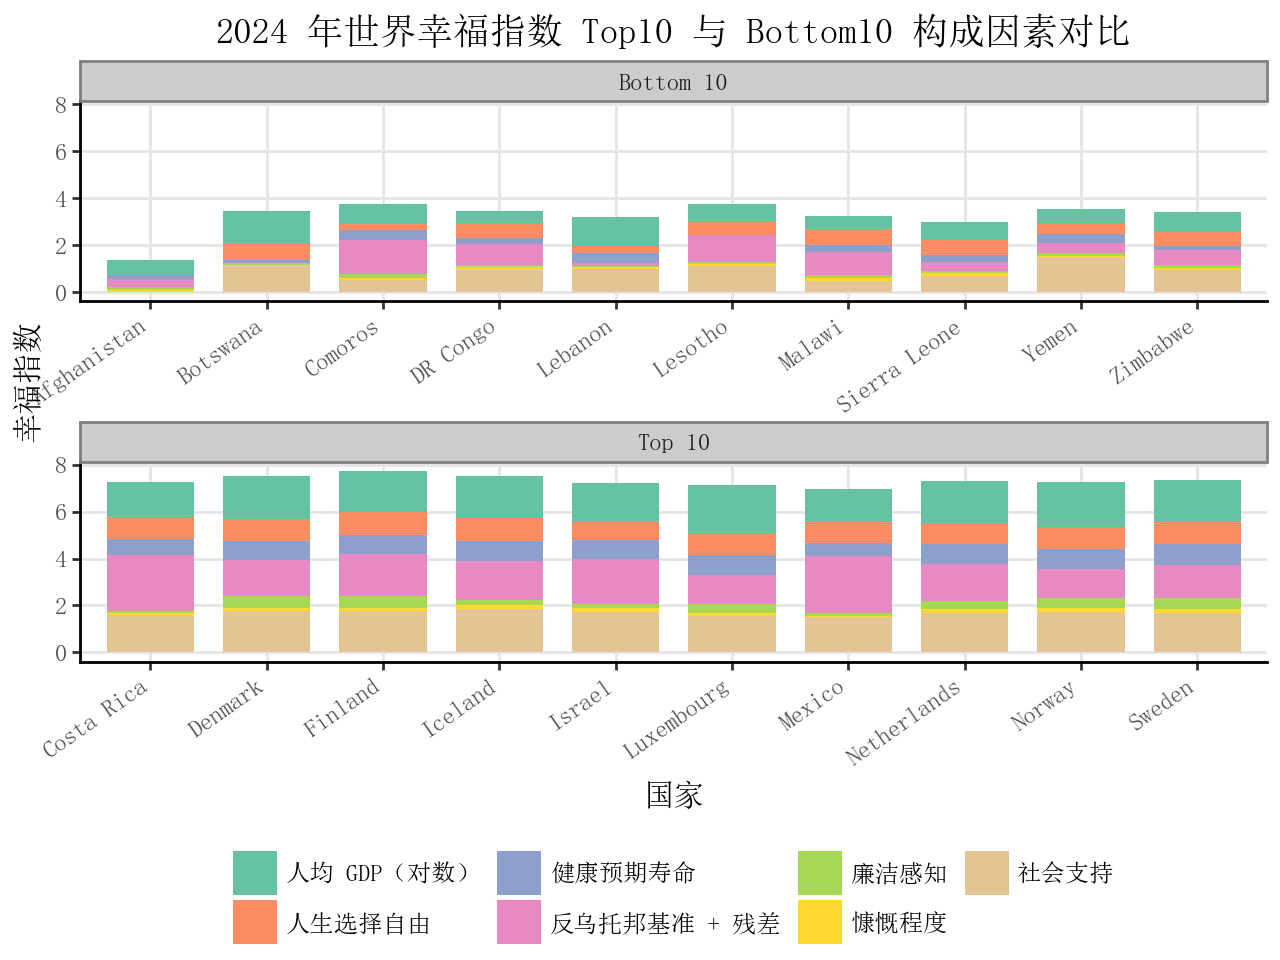

In [10]:
# 为 Top10 / Bottom10 添加分组标签
top10_long["Group"] = "Top 10"
bottom10_long["Group"] = "Bottom 10"

compare_long = pd.concat([top10_long, bottom10_long], ignore_index=True)

p_compare = (
    ggplot(compare_long, aes(x="Country name", y="Contribution", fill="Factor_zh"))
    + geom_col(width=0.75)
    + facet_wrap("~Group", nrow=2, scales="free_x")
    + scale_fill_brewer(type="qual", palette="Set2")
    + ggtitle("2024 年世界幸福指数 Top10 与 Bottom10 构成因素对比")
    + xlab("国家")
    + ylab("幸福指数")
)
p_compare


### 4.6 代表性国家幸福指数的时间演变
 
 前文的分析主要基于 2024 年这一年份的截面数据，聚焦于不同国家在同一时间点上的
 幸福指数构成差异。为了进一步理解“幸福感是如何在时间维度上变化”的，本节选取
 2024 年幸福指数排名前 10 的国家，回溯其近若干年（最多近 10 年）的幸福指数走势。
 
 具体做法如下：
 
 - 使用原始数据表 `WHR25_Data_Figure_2.1v3.xlsx` 中所有年份的信息；  
 - 筛选出 2024 年 Top10 国家在各年份的 `Life evaluation (3-year average)` 指标；  
 - 构造一个“年份 × 国家”的数据透视表，用于在论文中以表格形式引用；  
 - 使用折线图展示代表性国家幸福指数随年份的变化趋势。
 
 通过这一时间维度的补充，可以观察到不同高幸福国家之间在长期趋势上的差异：
 有的国家保持稳定高位，有的国家则呈现出逐步上升或略有回落的轨迹，这为理解
 幸福指数背后的长期制度与社会变迁提供了直观线索。


2024 年 Top10 国家近年幸福指数（Life evaluation, 3-year average）表：


Country name,Costa Rica,Denmark,Finland,Iceland,Israel,Luxembourg,Mexico,Netherlands,Norway,Sweden
Year,,,,,,,,,,
2015,7.087,7.526,7.413,7.501,7.267,6.871,6.778,7.339,7.498,7.291
2016,7.079,7.522,7.469,7.504,7.213,6.863,6.578,7.377,7.537,7.284
2017,7.072,7.555,7.632,7.495,7.190,6.910,6.488,7.441,7.594,7.314
2018,7.167,7.600,7.769,7.494,7.139,7.090,6.595,7.488,7.554,7.343
2019,7.121,7.646,7.809,7.504,7.129,7.238,6.465,7.449,7.488,7.353
2020,7.069,7.620,7.842,7.554,7.157,7.324,6.317,7.464,7.392,7.363
2021,6.582,7.636,7.821,7.557,7.364,7.404,6.128,7.415,7.365,7.384
2022,6.609,7.586,7.804,7.530,7.473,7.228,6.330,7.403,7.315,7.395
2023,6.955,7.583,7.741,7.525,7.341,7.122,6.678,7.319,7.302,7.344


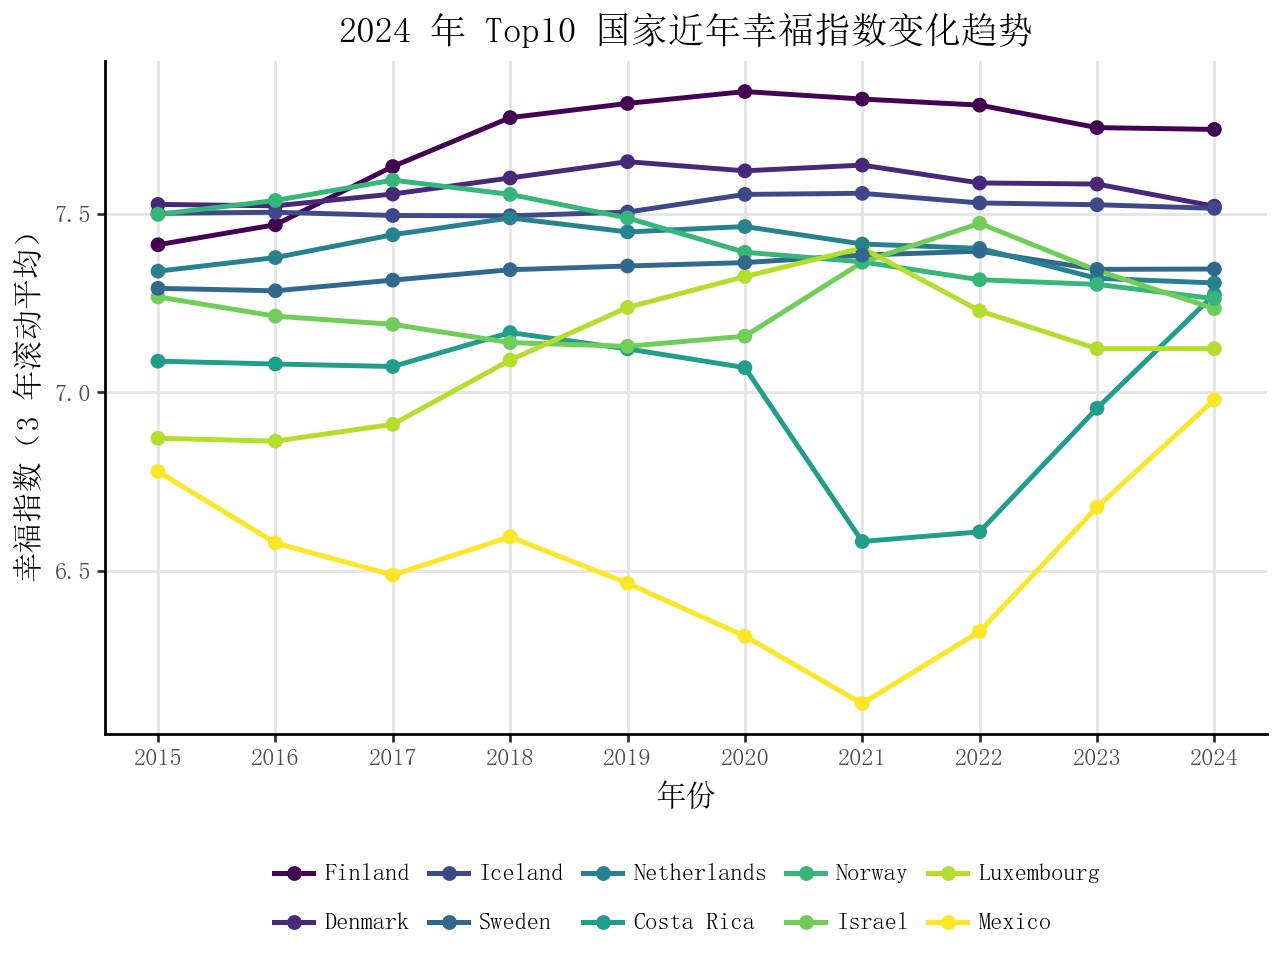

In [11]:
# %%
# 1. 抽取 2024 年 Top10 国家在所有年份的幸福指数数据
top_countries = top10_renamed["Country name"].unique()

whr_top_hist = whr[whr["Country name"].isin(top_countries)].copy()

# 只保留最近 10 年（如果年份不满 10 年，就全用）
max_year = whr_top_hist["Year"].max()
min_year = max_year - 9
whr_top_hist = whr_top_hist[whr_top_hist["Year"].between(min_year, max_year)]

# 按年份排序，方便阅读
whr_top_hist = whr_top_hist.sort_values(["Year", "Country name"])

# 2. 构造“年份 × 国家”的透视表，便于在论文中以表格形式插入
pivot_top_hist = (
    whr_top_hist
    .pivot_table(
        index="Year",
        columns="Country name",
        values="Life evaluation (3-year average)"
    )
    .round(3)
)

print("2024 年 Top10 国家近年幸福指数（Life evaluation, 3-year average）表：")
display(pivot_top_hist)

# 3. 绘制折线图：Top10 国家幸福指数的时间演变
#    为了让颜色与前文一致，仍然按照国家区分颜色
#    将 Country name 设置为有序类别，顺序与前面 Top10 图一致
whr_top_hist["Country name"] = pd.Categorical(
    whr_top_hist["Country name"],
    categories=ordered_countries_top,
    ordered=True,
)

p_top_trend = (
    ggplot(
        whr_top_hist,
        aes(
            x="Year",
            y="Life evaluation (3-year average)",
            color="Country name",
            group="Country name",
        )
    )
    + geom_line(size=1)
    + geom_point(size=2)
    + scale_x_continuous(
        breaks=sorted(whr_top_hist["Year"].unique())
    )
    + ggtitle("2024 年 Top10 国家近年幸福指数变化趋势")
    + xlab("年份")
    + ylab("幸福指数（3 年滚动平均）")
    + theme_bw()
    + theme(
        text=element_text(family=CHINESE_FONT),
        legend_position="bottom",
        legend_direction="horizontal",
        legend_title=element_blank(),
        axis_text_x=element_text(rotation=0),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        axis_line=element_line(size=1.0, color="black"),
    )
)
p_top_trend


## 5. 讨论（Discussion）

基于图中对 2024 年世界幸福指数 Top10 与 Bottom10 国家构成因素的可视化结果，可以从社会发展水平、制度环境以及幸福感的多维度特性三个方面展开分析。可视化呈现出的差异不仅是“幸福水平高低”的对比，更揭示了不同国家在结构性指标上的深刻分化，这对于理解幸福感的社会学机制具有重要意义。



### 1. 经济发展仍是基础，但解释力正在下降

图表显示，Top10 国家在“人均 GDP（对数）”上的得分普遍高于 Bottom10 国家，经济发展水平依旧是支撑幸福感的重要因素。较高的收入水平能够提升生活质量、医疗条件和教育资源，为个体提供更广泛的选择空间。

但与此同时，图中也可见：部分经济指标不算极端低的 Bottom10 国家，其总体幸福水平仍显著落后。这表明**经济增长的边际幸福效应正在减弱**。幸福感的提升越来越依赖社会与制度层面的“软性条件”，而不再仅由经济单一因素决定。



### 2. 社会支持与制度保障在幸福形成中占据核心地位

在 Top10 国家中，“社会支持（Social support）”和“人生选择自由（Freedom）”两个指标贡献度突出，且呈现出高度稳定性。图中的北欧国家尤其具有典型性：其社会支持体系完善、社区互信度高、政府透明度强，使人们在遭遇风险时能获得及时援助，也使个体在生活规划上拥有更大的自主性。

相比之下，Bottom10 国家在这两项指标上普遍得分偏低。缺乏社会安全网、劳动力市场弹性差、公共服务薄弱，使得居民容易陷入“脆弱生活状态”，幸福感自然受到显著影响。

从社会学视角来看，**社会支持是“关系性幸福”的核心变量**，它能增强社会凝聚力、减少孤立与焦虑，而这些恰恰是经济增长难以直接提供的。


### 3. 廉洁感知（感知腐败）与制度信任深刻影响主观幸福

图中可见，“廉洁感知（Perceptions of corruption）”在 Top10 国家中保持正向贡献，而在 Bottom10 中往往接近零甚至略为负向。腐败不仅阻碍经济发展，更破坏社会信任，使人们对政府、公共资源分配以及未来预期产生怀疑。

从制度社会学的角度来看，社会信任是幸福感的重要来源。一旦人们认为制度不透明、不公平，幸福感就难以建立。图中的差异说明：**良好的制度环境本身就是一种“无形的幸福资本”**。



### 4. “Dystopia + residual” 高企揭示模型外部的结构性问题

Bottom10 国家普遍呈现“Dystopia + residual”贡献占比过高，这意味着模型能够解释的积极因素在这些国家中严重不足。该部分往往代表：

- 战乱、政治动荡  
- 极端贫困与医疗资源不足  
- 社会暴力、性别不平等  
- 弱治理能力与制度信任崩塌  
- 历史创伤或长期边缘化

这一高占比揭示：**幸福差距并不是单纯的经济差距，而是深层次社会结构差距的体现**。这也说明现有指标体系难以捕捉这些国家的复杂困境，未来研究需纳入更多社会心理与制度变量。



### 5. Top10 与 Bottom10 存在明显的“结构性断层”

图表清楚展示出：  
**Top10 的幸福构成呈“多元支撑型”，而 Bottom10 则呈“单薄脆弱型”。**

- Top10：经济、健康、社会支持、自由等多维指标均衡发展  
- Bottom10：多项指标同时偏低，难以形成互补机制  

这意味着幸福感的形成依赖“多维资源”的共同作用。当某一维度薄弱时，其他维度仍能弥补；而在 Bottom10 国家，多重短板叠加，使幸福提升困难重重。

这种结构性差异是全球幸福不平等的重要来源，也体现了不同国家在社会发展路径上的长期分化。

### 6. Top10 国家幸福指数的时间演变：稳定性与阶段性波动并存

从新增的时间序列可视化结果来看，2024 年 Top10 国家在近 10 年间整体呈现出较高且稳定的幸福指数水平，但不同国家之间仍存在显著差异。

首先，**芬兰、丹麦、冰岛等北欧国家呈现“长期稳定高位”的趋势**。从 2015–2024 的折线图可见，这些国家的幸福指数波动幅度较小，大多数年份稳定在 7.5 分以上，并在 2017–2020 年期间略有上升。这种稳定性反映了北欧国家在社会支持体系、公共治理、生活自由度等方面持续良好的制度环境。

其次，**以卢森堡、荷兰、瑞典为代表的西欧国家表现为“温和上升或小幅波动”**。这些国家在十年间整体幸福指数保持在 7.2–7.6 区间上下浮动，虽然不及北欧国家的高稳定性，但整体趋势呈现缓慢上扬，说明经济稳定增长与持续完善的社会福利体系在维持幸福水平方面仍然发挥着稳固作用。

相比之下，**墨西哥与哥斯达黎加等美洲国家在时间维度上呈现出较为明显的波动**。例如图中的墨西哥幸福指数在 2020–2022 年期间出现显著下降，2022 年达到十年低点，这与疫情冲击、社会治安问题以及经济不确定性增加密切相关；而在 2023–2024 年稍有回升，说明其幸福指标对外部环境更为敏感。

总体而言，时间趋势图揭示出：  
- 高幸福国家的优势不仅体现在截面数据中，也体现在**长期稳定性**上；  
- 幸福感的形成具有明显的结构性与持续性，高幸福国家往往能够维持良好的社会制度与公共治理；  
- 波动较大的国家通常受到外部冲击（经济、政治、公共安全等）影响，这也反映幸福指数中“社会韧性（social resilience）”的重要性。

这些现象与前文基于构成因素的结构分析结果相互印证：幸福指数不仅由当前的经济与社会条件决定，更依赖长期制度质量与社会信任度的积累。



## 6. 结论与局限（Conclusion & Limitations）

本文以 2024 年世界幸福指数 Top10 与 Bottom10 国家为对象，通过叠加条形图对幸福指数的构成因素进行了可视化分析。整体来看，幸福水平较高的国家普遍拥有更好的经济基础、更完善的社会支持体系以及更强的制度透明度；而低幸福国家在多数指标上均表现偏弱，呈现明显的结构性短板。

从图表中可以得出以下结论：

1. **经济与健康是支撑幸福的基础因素**，Top10 国家在这些维度上普遍表现更好。  
2. **社会支持与人生选择自由是区分高幸福与低幸福国家的核心变量**，在高幸福国家中占比更高。  
3. **廉洁感知在高幸福国家具有稳定贡献**，说明制度信任与公共治理质量对幸福具有重要影响。  
4. **Bottom10 国家中“Dystopia + residual” 占比较大**，反映出其幸福构成依赖度更高、解释性变量更少，幸福提升受到多重限制。
5. **幸福指数在时间维度上呈现稳定性差异，反映国家制度韧性。**  
   通过对 2024 年 Top10 国家近 10 年幸福指数的时间趋势分析可以发现，高幸福国家通常具有更强的长期稳定性，幸福指数在多年间波动较小；而一些国家的幸福指数在疫情阶段出现显著下滑，也说明幸福感对社会风险、经济不确定性与公共治理质量具有敏感性。这表明幸福指数不仅是某一年份的状态，更是长期制度质量、社会信任与公共服务稳定性的结果。


本文也存在一定局限性：仅选取 Top10 与 Bottom10 的样本，未覆盖中间国家；分析仅基于单一年份，缺少时间趋势；可视化手段以条形图为主，尚未结合统计建模。此外，尽管本文加入了对 Top10 国家幸福指数时间趋势的分析，但仍未涵盖 Bottom10 国家在长期序列中的变化；未来研究可扩展时间维度，以更全面地理解全球幸福水平的动态机制。


未来可在引入多年份数据、扩展样本范围，以及使用更多可视化与分析方法方面进一步完善研究。
